**Cancer Detection by using Chest CT Scan pictures with the help of computer vision and CNN, tensorflow**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!unzip "/content/drive/MyDrive/Chest cancer CT-Scan.zip"

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os   #for files and dir
import math
import shutil #we can move file from one file to another
import glob
import cv2 #computer Vision

In [ ]:
#count the no of images in the respective classes 0 - NO Brain Tumor and 1 - Brain Tumor
ROOT_DIR = "/content/Chest cancer CT-Scan/Data"
num_of_images = {}
for dir in os.listdir(ROOT_DIR):
  num_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

In [ ]:
num_of_images.items()

dict_items([('train', 4), ('test', 4), ('valid', 4)])

In [ ]:
os.listdir("/content/Chest cancer CT-Scan/Data")

['train', 'test', 'valid']

In [ ]:
test_dir = "/content/Chest cancer CT-Scan/Data/test"
train_dir = "/content/Chest cancer CT-Scan/Data/train"
valid_dir = "/content/Chest cancer CT-Scan/Data/valid"

In [ ]:
# train sets
for files in os.listdir(train_dir):
    print(os.path.join(train_dir,files))

print('\n')
# valid sets
for files in os.listdir(valid_dir):
    print(os.path.join(valid_dir,files))

print('\n')
# test sets
for files in os.listdir(test_dir):
    print(os.path.join(test_dir,files))

/content/Chest cancer CT-Scan/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/Chest cancer CT-Scan/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/Chest cancer CT-Scan/Data/train/normal
/content/Chest cancer CT-Scan/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


/content/Chest cancer CT-Scan/Data/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/Chest cancer CT-Scan/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/Chest cancer CT-Scan/Data/valid/normal
/content/Chest cancer CT-Scan/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


/content/Chest cancer CT-Scan/Data/test/normal
/content/Chest cancer CT-Scan/Data/test/squamous.cell.carcinoma
/content/Chest cancer CT-Scan/Data/test/large.cell.carcinoma
/content/Chest cancer CT-Scan/Data/test/adenocarcinoma


In [ ]:
from skimage import io
from skimage.color import rgb2gray
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras import layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from keras import optimizers
from keras.applications import resnet


In [ ]:
tf.__version__

'2.11.0'

Set globals


In [ ]:
BATCH_SIZE = 32
EPOCHS = 30
SEED = 49
H = 300 #Height
W = 400 #Width
IMAGE_SHAPE = (460,460,3)
N_CLASSES = 4
STEPS = 20

Set visualization defaults


In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['xtick.color'] = 'dimgrey'
plt.rcParams['ytick.color'] = 'dimgrey'
plt.rcParams['axes.labelcolor'] = 'dimgrey'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

Setup GPU accelerator - configure Strategy


In [ ]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) #Assume TPU
except ValueError:
    strategy = tf.distribute.get_strategy() #if not TPU, set default for GPU/CPU

Pre-Processing images

In [ ]:
# Training Images

"""
  input : Path
  output : Pre processed images    """
trainImg_data = ImageDataGenerator(dtype='float32') #data augmentation
train_image = trainImg_data.flow_from_directory(train_dir, target_size = (460,460), batch_size = BATCH_SIZE, class_mode = 'categorical')



Found 613 images belonging to 4 classes.


In [ ]:
# Testing Images

testImg_data = ImageDataGenerator(dtype='float32')
test_image = testImg_data.flow_from_directory(test_dir,  target_size = (460, 460), batch_size = BATCH_SIZE, class_mode = 'categorical')


Found 315 images belonging to 4 classes.


In [ ]:
# Validation Images

validImg_data = ImageDataGenerator(dtype='float32')
valid_image = validImg_data.flow_from_directory(valid_dir,  target_size = (460, 460), batch_size = BATCH_SIZE, class_mode = 'categorical')


Found 72 images belonging to 4 classes.



###Model Building

In [ ]:
#ResNet50 Model
with strategy.scope(): #use TPU/GPU strategy

    res_model = ResNet50(include_top=False,
                         pooling='avg',
                         weights='imagenet',
                         input_shape = (IMAGE_SHAPE))

    for layer in res_model.layers:
        if 'conv5' not in layer.name:
            layer.trainable = False
with strategy.scope(): #use TPU/GPU strategy

    res_model = ResNet50(include_top=False,
                         pooling='avg',
                         weights='imagenet',
                         input_shape = (IMAGE_SHAPE))

    for layer in res_model.layers:
        if 'conv5' not in layer.name:
            layer.trainable = False

    resnet_model = Sequential()
    resnet_model.add(res_model)
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Flatten())
    resnet_model.add(BatchNormalization())
    resnet_model.add(Dropout(0.4))
    resnet_model.add(Dense(N_CLASSES, activation='softmax'))
    resnet_model.summary()

    adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.00001,
                                         decay= 1e-5)
    #compiling the model
    resnet_model.compile(optimizer=adam_optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy']) #need to update to use f1 score too


Early stopping

In [ ]:
#Early stoping and model check point
from keras.callbacks import  ModelCheckpoint, EarlyStopping

from keras.models import Model
#early stopping
checkpoint = ModelCheckpoint(filepath='./transfer_model.hdf5',
                               monitor='val_loss',
                               verbose = 1,
                               save_best_only=True)

early_stopping = EarlyStopping(verbose=1,
                               patience=2)


#Model Training














































,

In [ ]:
history_model = resnet_model.fit(train_image,
                               epochs = EPOCHS,
                               verbose = 1,
                               validation_data = valid_image,
                               callbacks = [checkpoint, early_stopping])

In [ ]:
#Model Graphical Interpretation
h = model.history
h.keys()

Ploting Graphs

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("acc vs val-acc")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")

plt.title("loss vs val-loss")
plt.show()

# Checking Model Accuracy

In [ ]:

from keras.models import load_model

model = load_model("/content/transfer_model.hdf5")


In [ ]:
acc = model.evaluate_generator(test_image)[1]
print(f"the accuracy of our model is {acc*100} %")

the accuracy of our model is 88.57142925262451 %


# confusion matrics

In [ ]:
Y_pred = model.predict(test_image, test_image.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
import sklearn.metrics as metrics
val_trues =test_image.classes
from sklearn.metrics import classification_report
print(classification_report(val_trues, val_preds))

10/10 [==============================] - 344s 33s/step
              precision    recall  f1-score   support

           0       0.36      0.33      0.34       120
           1       0.13      0.14      0.14        51
           2       0.13      0.13      0.13        54
           3       0.27      0.30      0.28        90

    accuracy                           0.25       315
   macro avg       0.22      0.22      0.22       315
weighted avg       0.26      0.25      0.25       315



In [ ]:
Y_pred = model.predict(test_image, test_image.samples / BATCH_SIZE)
val_preds = np.argmax(Y_pred, axis=1)
val_trues =test_image.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

10/10 [==============================] - 324s 30s/step


array([[37, 22, 21, 40],
       [18, 11, 11, 11],
       [20,  7,  6, 21],
       [34, 12, 15, 29]])

# Loading Images for Prediction

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

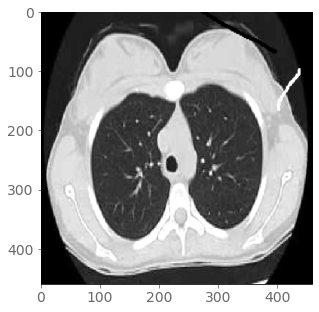

1/1 [==============================] - 1s 729ms/step
0.002357958
Index: 0


In [ ]:
# Old code
path = "/content/Chest cancer CT-Scan/Data/test/normal/10 - Copy (2).png"
img = load_img(path, target_size = (460,460))
input_arr = img_to_array(img)/225   #dividing by 255 for normalizing the image
input_arr.shape

#ploting image
plt.imshow(input_arr)
plt.show()

input_arr = np.expand_dims(input_arr, axis = 0 )
pred = model.predict(input_arr)[0][0]
# pred = (model.predict(input_arr) > 0.5)*1
# score = tf.nn.softmax(pred[0])
pred
print(pred)
print('Index:',np.argmax(pred))


In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
img_path = "/content/Chest cancer CT-Scan/Data/test/squamous.cell.carcinoma/000115 (4).png"
img = load_img(img_path, target_size=(460, 460))
x = img_to_array(img)/225
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds=model.predict(x)
# preds = (model.predict(x) > 0.5)*1
# create a list containing the class labels
class_labels = ['adenocarcinoma', 'large.cell.carcinoma','normal',  'squamous.cell.carcinoma']
# find the index of the class with maximum score
pred = np.argmax(preds, axis=-1)
# print the label of the class with maximum score
print(class_labels[pred[0]])

1/1 [==============================] - 1s 735ms/step
normal


In [ ]:
test_image.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [ ]:
images =test_image.class_indices
print(images)

{'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
